In [1]:
import json
import requests
from bs4 import BeautifulSoup
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from wordcloud import WordCloud

In [2]:
TRACKS_FILE_NAME = 'top_hits.json'

In [3]:
with open('../data/top_hits.json') as json_file:
    tracks = json.load(json_file)

In [4]:
df = pd.DataFrame(tracks)

In [5]:
df.shape

(2918, 33)

In [6]:
df['year']=df['album'].apply(lambda x: x.get('release_date')[:4])
df['decade'] = df['year'].apply(lambda x: x[:3]+'0')

In [7]:
df['primary_artist'] = df['artists'].apply(lambda x: x[0]['name'])

In [8]:
df['artists'] = df['artists'].apply(lambda x: [artist['name'] for artist in x])

In [9]:
df.columns

Index(['acousticness', 'album', 'analysis_url', 'artists', 'available_markets',
       'danceability', 'disc_number', 'duration_ms', 'energy', 'episode',
       'explicit', 'external_ids', 'external_urls', 'href', 'id',
       'instrumentalness', 'is_local', 'key', 'liveness', 'loudness', 'mode',
       'name', 'popularity', 'preview_url', 'speechiness', 'tempo',
       'time_signature', 'track', 'track_href', 'track_number', 'type', 'uri',
       'valence', 'year', 'decade', 'primary_artist'],
      dtype='object')

### Distributions

/home/mkrsteska/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


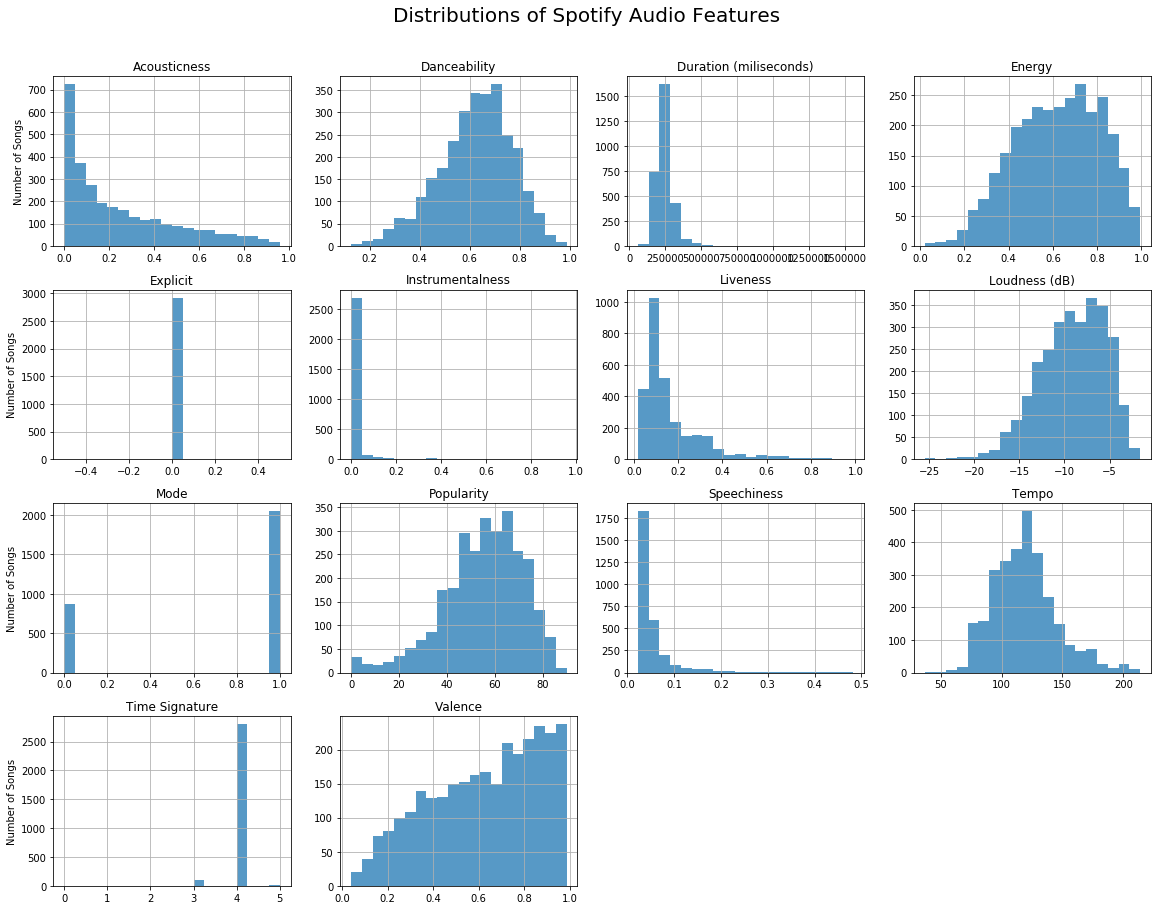

In [10]:
ax = df[['acousticness', 'danceability', 'duration_ms', 'energy',
           'explicit', 'instrumentalness', 'liveness', 'loudness', 'mode',
           'popularity', 'speechiness', 'tempo', 'time_signature', 'valence']].\
            hist(figsize=(16,12), bins=20, alpha=0.75);
ax = ax.ravel()
plt.tight_layout()

titles = ['Acousticness', 'Danceability', 'Duration (miliseconds)', 'Energy',
          'Explicit', 'Instrumentalness', 'Liveness', 'Loudness (dB)', 'Mode',
          'Popularity', 'Speechiness', 'Tempo', 'Time Signature', 'Valence']

for i in range(len(ax)-2):
    ax[i].set_title(titles[i])
    if i % 4 == 0:
        ax[i].set_ylabel('Number of Songs')
plt.suptitle('Distributions of Spotify Audio Features', fontsize=20, y=1.05);
plt.show()

We have here a few graphs plotting the distribution of our songs grouped by feature. A few things are already noticeable at this point of our EDA:
- most of the songs have a low acousticness, probably due to the fact of the emergence of electronic-based beats/instrumentals in the music industry during the last few decades
- none of our songs contain explicit words
- the big majority of our songs have a low instrumentalness
- speechness is high in a minority of our songs, which means that the majority of our songs do not contain a lot of text/lyrics; this result is pulled up by the minority of rap/hip-hop songs that by essence contain a lot of text


### Correlation heatmap 

In [11]:
num_df_attributes = df[['acousticness', 'danceability', 'duration_ms', 'energy',
           'instrumentalness', 'liveness', 'loudness', 'mode',
           'popularity', 'speechiness', 'tempo', 'time_signature', 'valence']]

num_df_attributes.corr('spearman')['popularity']

acousticness       -0.152343
danceability        0.042441
duration_ms         0.032648
energy              0.129047
instrumentalness   -0.152428
liveness            0.001720
loudness            0.311193
mode               -0.060100
popularity          1.000000
speechiness         0.097810
tempo              -0.012831
time_signature      0.048770
valence            -0.128739
Name: popularity, dtype: float64

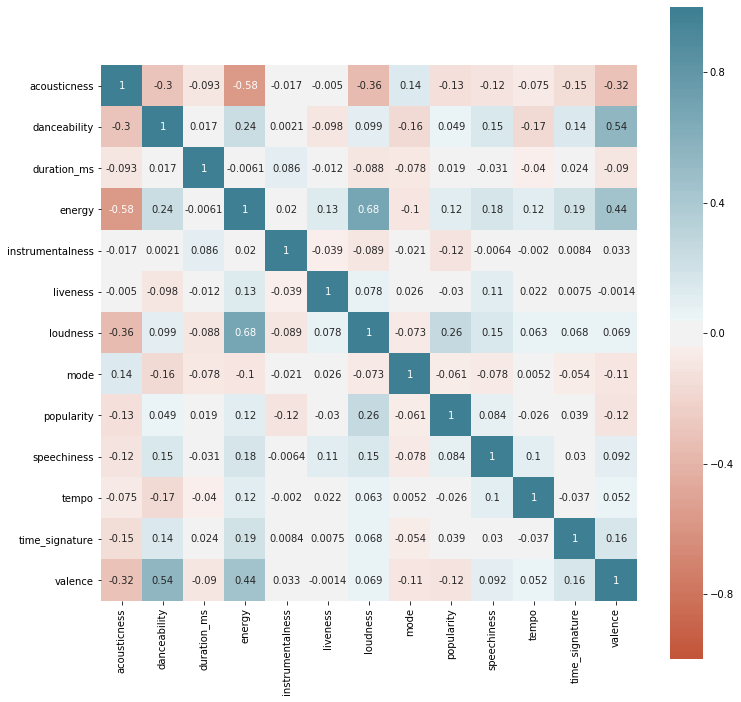

In [12]:
fig, ax = plt.subplots(figsize=(12,12))   
sns.heatmap(
    num_df_attributes.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    ax = ax
)

We can see on this heatmap the positive correlation of all pairs of features from our songs:
- The two highest correlated features are energy and loudness, which makes sense (the correlation graph of these two features is shown down below)
- The two second highest correlated features are energy and acousticness, which basically means the same thing as the previous correlation between energy and loudness
- The third highest corelated features are danceability and valence, which means that the happier is the song, the more danceble it is

We can also see the negative correlations:
- The highest negative correlation is between energy and acousticness, basicly lound songs aren't acoustic
- The second highest negative correlation is achieved between loudness and acousticness, which means that the louder the song, the less acoustic it is
- The third highest negative correlation is between valence and acousticness, wich means that the sad songs are often acoustic


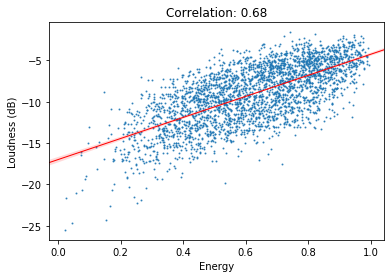

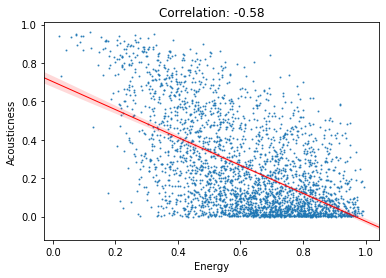

In [13]:
ax = sns.regplot(x=df['energy'], y=df['loudness'], line_kws= {'linewidth': 1, 'color': 'red'}, scatter_kws={'s': 1})
ax.set(title='Correlation: 0.68')
ax.set(xlabel='Energy', ylabel='Loudness (dB)')
plt.show()
ax1 = sns.regplot(x=df['energy'], y=df['acousticness'], line_kws= {'linewidth': 1, 'color': 'red'}, scatter_kws={'s': 1})
ax1.set(title='Correlation: -0.58')
ax1.set(xlabel='Energy', ylabel='Acousticness')
plt.show()

Above are the plot representations of the highest positive and negative correlations mentioned on the heatmap :
- On the first plot, we can, in fact, see that there is a positive linear correlation between loudness and energy in a song.
- On the second plot, we can see that there is a negative linear correlation between acousticness and energy in a song. It does not fit the data. 

### Boxplots over decades

In [14]:
audio_features=['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness',
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

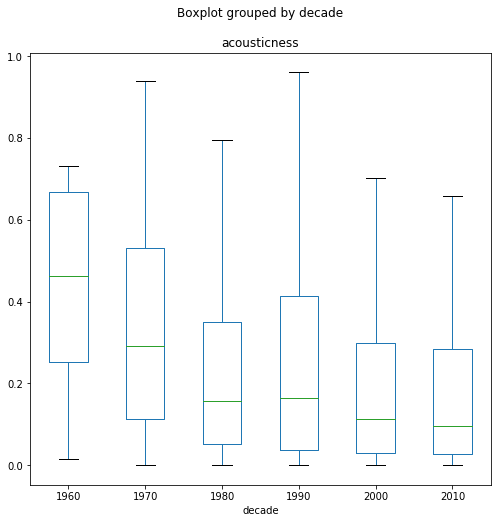

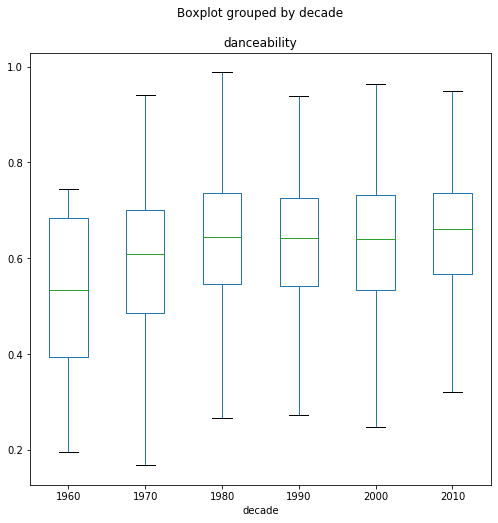

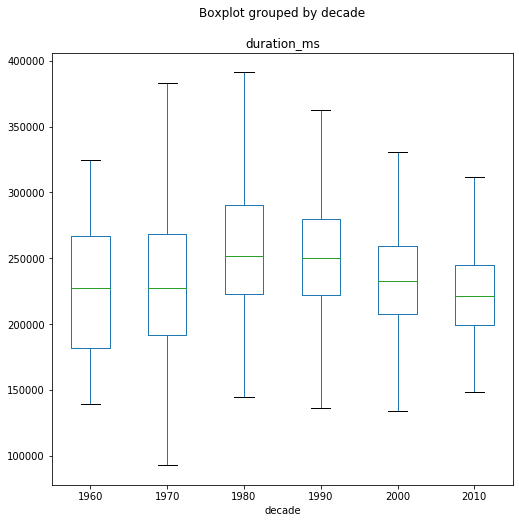

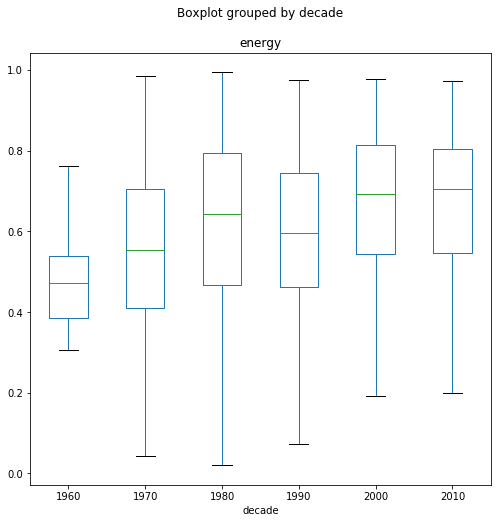

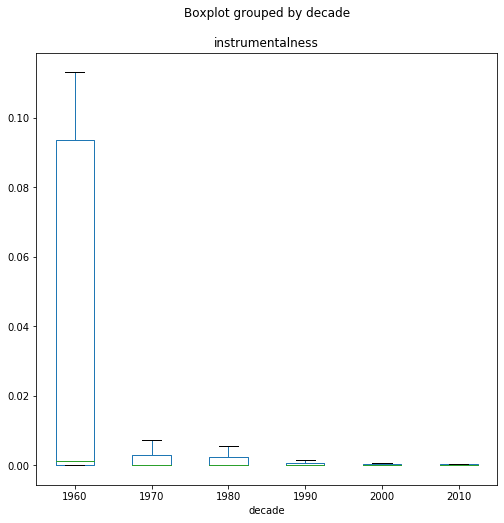

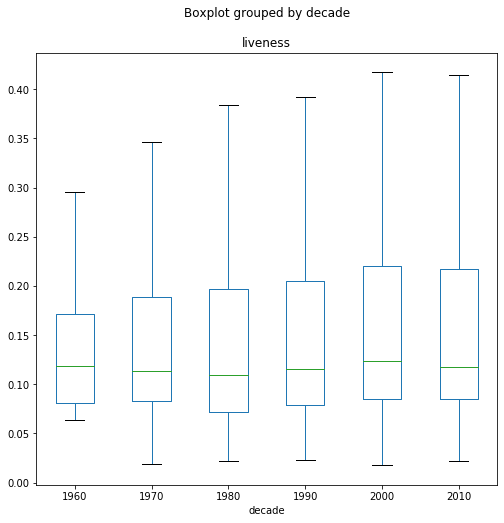

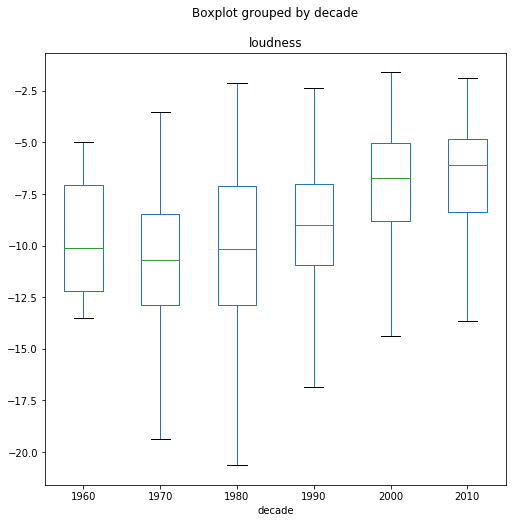

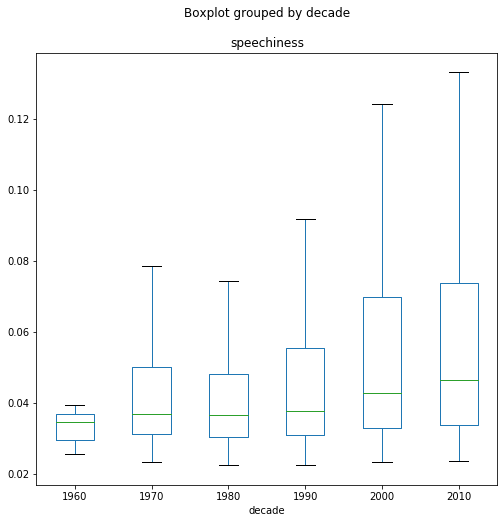

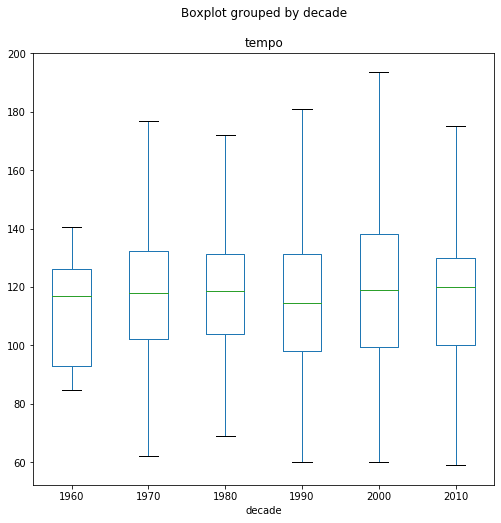

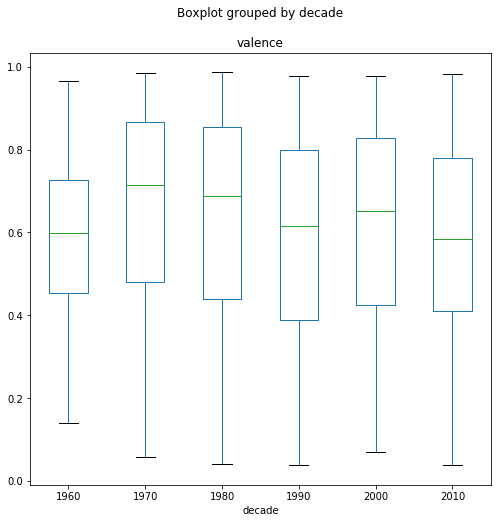

In [15]:
for feature in audio_features:
    fig, ax = plt.subplots(figsize=(8,8))
    plt.suptitle('')
    ax.grid(False)
    df.boxplot(column=[feature], by='decade', ax=ax, showfliers=False, grid=False)
    plt.show()

From these boxplots we can identify a few trends:
- acousticness seems to have decreased as well over time, probably due to the emergence of electronic-based musics which contain less real acoustic instruments that "traditional" songs
- duration has slightly decreased since the 70's: we can indeed state that more and more songs are short than before
- energy has increased over time, which could be explained by the fact that 
- speechness has increased over time, certainly due to the emergence of rap/hip-hop music, which contain a lot of text by essence

### Most populart artists

In [16]:
df['primary_artist'].value_counts().head(10)

Madonna                    27
Michael Jackson            27
Elton John                 24
Mariah Carey               19
Daryl Hall & John Oates    18
Stevie Wonder              18
Janet Jackson              17
Whitney Houston            16
Rihanna                    14
Chicago                    14
Name: primary_artist, dtype: int64

Text(0.5, 1.0, 'Most Popular Artists')

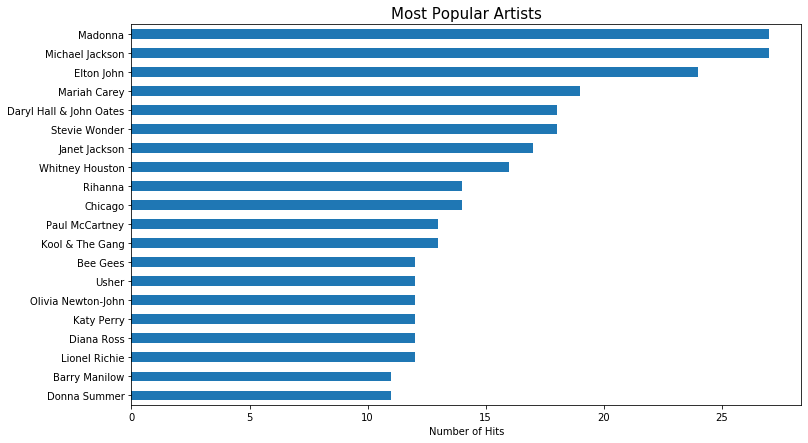

In [17]:
ax = df['primary_artist'].value_counts().sort_values().tail(20).plot.barh(figsize=(12,7))
ax.set(xlabel='Number of Hits')
ax.set_title('Most Popular Artists', fontsize=15)

It looks like Michael Jackson and Madonna are still the artists which have the most hit songs for the past 40 years, followed by Elton John and Mariah Carey. 
The fact that only "old" artists are the most popular can be explained by the rising concurrence between artists: as there are more artists today than before, it was easier to stay in the top list back in the days than today (more songs can challenge the top hits today than before). 

In [18]:
top_artists = df.groupby('primary_artist')['name'].count()
top_artists = top_artists[top_artists >= 5]
audio_features=['acousticness', 'danceability', 'energy','instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
X_artists = df.groupby('primary_artist')[audio_features].mean()
X_artists = X_artists.reindex(top_artists.index)

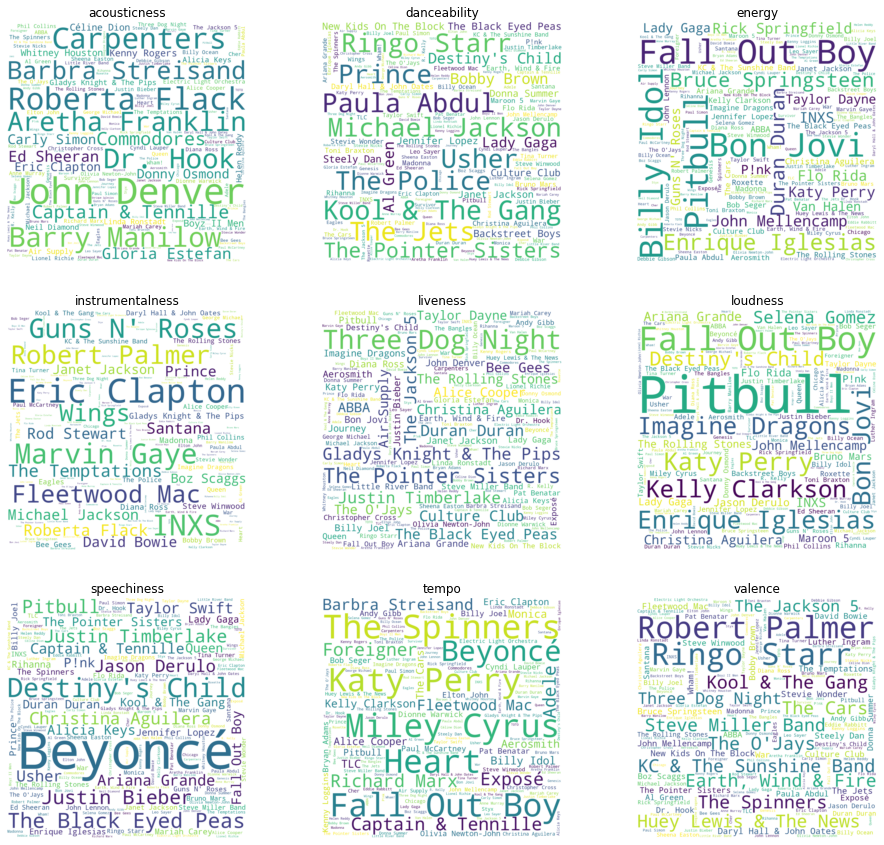

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(16,15))
ax = ax.ravel()

for i in range(len(audio_features)):
    # word-weight dictionary
    feature = X_artists[audio_features[i]] + 1e-3
    dictionary = dict(zip(X_artists.index, feature))
    
    wordcloud = WordCloud(background_color='white', height=1400, width=1400, min_font_size=5, max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title(audio_features[i])
    ax[i].axis('off')

With the artists word clouds we can see that liveness is the one that doesn't have a leading artist. The livesness is almost uniform throughout the artists. We can still se that Three Dog Night has the most liveness in the cloud.